# Imports

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

#device = 0
#torch.cuda.set_device(device)

%reload_ext autoreload
%autoreload 2
#%matplotlib notebook
%matplotlib inline


import sys

sys.path.append('../fastai/')
import fastai
from fastai.vision import *
from fastai.vision.learner import model_meta

sys.path.append('../models-pytorch/pretrained-models.pytorch')
import pretrainedmodels
from pretrainedmodels import *

from typing import Dict
import pandas as pd
import numpy as np
import os
import torch
import torchvision
from torchvision.models import *
from torchsummary import summary
from pathlib import Path
from functools import partial, update_wrapper
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
import shutil


PATH = Path('/home/Deep_Learner/private/network/datasets/Hypophysenadenome-Rezidive/')
PATH_LOCAL = Path('/home/Deep_Learner/private/local/')
WSIS_RELAPSE = PATH/'wsis_relapse'
TILES_RELAPSE = PATH_LOCAL/'tiles_relapse'
TILES_NON_RELAPSE = PATH_LOCAL/'tiles_non_relapse'

LABELS_NAME = 'rezidive-gescannt.xlsx'
LABELS = PATH/LABELS_NAME



nw = 16   #number of workers for data loader
torch.backends.cudnn.benchmark=True

#def batch_stats(self, funcs:Collection[Callable]=None)->Tensor:
#        "Grab a batch of data and call reduction function `func` per channel"
#        funcs = ifnone(funcs, [torch.mean,torch.std])
#        x = self.one_batch(ds_type=DatasetType.Train, denorm=False)[0].cpu()
#        return [func(channel_view(x), 1) for func in funcs]
#        
#vision.data.ImageDataBunch.batch_stats = batch_stats

sz = 512
bs = 6

#fastai defaults
tta_beta = 0.4 
tta_scale = 1.35
dropout = 0.5
wd = 0.01

seed = 54
np.random.seed(seed)

num2lbs = {
    0:"non_relapse", 
    1:"relapse"
}

lbs2num = {l:n for n,l in num2lbs.items()}

# Utils

In [2]:
from fastai.torch_core import flatten_model

def arch_summary(arch):
    model = arch(False)
    tot = 0
    for i, l in enumerate(model.children()):
        n_layers = len(flatten_model(l))
        tot += n_layers
        print(f'({i}) {l.__class__.__name__:<12}: {n_layers:<4}layers (total: {tot})')

def show(np):
    return util.np_to_pil(np)

Path.ls = lambda x: [p for p in list(x.iterdir()) if '.ipynb_checkpoints' not in p.name]

def show_multiple_images(path, rows = 3, figsize=(128, 64)):
    imgs = [open_image(p) for p in path.ls()]
    show_all(imgs=imgs, r=rows, figsize=figsize)
    
def show_multiple_images_big(path:pathlib.Path):
    for p in path.ls():
        plt.imshow(mpimg.imread(str(p)))
        plt.show()
        
def get_id_from_path(path):
    path = Path(path)
    split = path.stem.split('-')
    return f'{split[0]}-{split[1]}'

def flatten(list_of_lists):
    result = []
    for l in list_of_lists:
        if len(l) == 1:
            result.append(l[0])
        else:
            for elem in l:
                result.append(elem)
    return result

# Extra Models

In [3]:
#https://github.com/PPPW/deep-learning-random-explore/blob/master/CNN_archs/cnn_archs.ipynb

def identity(x): return x

def nasnetamobile(pretrained=True):
    pretrained = 'imagenet' if pretrained else None
    model = pretrainedmodels.nasnetamobile(pretrained=pretrained, num_classes=1000)  
    model.logits = identity
    model_meta[nasnetamobile] =  { 'cut': identity, 'split': lambda m: (list(m[0][0].children())[8], m[1]) }
    return nn.Sequential(model)

#arch_summary(lambda _: nasnetamobile(False)[0])

def se_resnext50_32x4d(pretrained=True):
    pretrained = 'imagenet' if pretrained else None
    model = pretrainedmodels.se_resnext50_32x4d(pretrained=pretrained)
    model_meta[se_resnext50_32x4d] =  {'cut': -2, 'split': lambda m: (m[0][3], m[1]) }
    return model

#arch_summary(lambda _: pretrainedmodels.se_resnext50_32x4d(pretrained=None))

def se_resnext101_32x4d(pretrained=True):
    pretrained = 'imagenet' if pretrained else None
    model = pretrainedmodels.se_resnext101_32x4d(pretrained=pretrained)
    model_meta[se_resnext101_32x4d] =  {'cut': -2, 'split': lambda m: (m[0][3], m[1]) }
    return model

def xception(pretrained=True):
    pretrained = 'imagenet' if pretrained else None
    model = pretrainedmodels.xception(pretrained=pretrained)
    model_meta[xception] =  { 'cut': -1, 'split': lambda m: (m[0][11], m[1]) }
    return model

def inceptionv4(pretrained=True):
    pretrained = 'imagenet' if pretrained else None
    model = pretrainedmodels.inceptionv4(pretrained=pretrained)
    model_meta[xception] =  { 'cut': -2, 'split': lambda m: (m[0][11], m[1]) }
    return model

# n 

In [4]:
#n='test'

n = np.load('n-rez.npy')
print(n)

m = n+1
m=6
np.save('n-rez', m)
print(m)

6
6


# Data 

## split dataset into train, valid and test set

In [5]:
df = pd.read_excel(LABELS).set_index('id')
test_pct = 0
valid_pct = 0.15

###
# RELAPSE
###

#key: patient, value: list of wsi names
patient_to_wsi_ids_relapse = {}
ids_relapse_all = [get_id_from_path(p) for p in (WSIS_RELAPSE.ls()) if p.suffix == '.ndpi']
excluded_ids = []
for id in ids_relapse_all:
    if id not in excluded_ids:
        patient = df.at[id, 'Patient']
        if patient in patient_to_wsi_ids_relapse.keys():
            patient_to_wsi_ids_relapse[patient].append(id)
        else:
            patient_to_wsi_ids_relapse[patient] = [id]
if test_pct != 0:            
    patients_relapse_train_and_valid, patients_relapse_test = train_test_split(list(patient_to_wsi_ids_relapse.keys()), 
                                                                               test_size=test_pct, 
                                                                               random_state=seed)
    patients_relapse_train, patients_relapse_valid = train_test_split(patients_relapse_train_and_valid, 
                                                                      test_size=valid_pct, 
                                                                      random_state=seed)
else:
    patients_relapse_train, patients_relapse_valid = train_test_split(list(patient_to_wsi_ids_relapse.keys()), 
                                                                      test_size=valid_pct, 
                                                                      random_state=seed)
    patients_relapse_test = []
    
    

ids_relapse_train = flatten([patient_to_wsi_ids_relapse[pat] for pat in patients_relapse_train])
ids_relapse_valid = flatten([patient_to_wsi_ids_relapse[pat] for pat in patients_relapse_valid])
ids_relapse_test = flatten([patient_to_wsi_ids_relapse[pat] for pat in patients_relapse_test])

tile_paths_relapse_all = [Path(f'{p.parts[-2]}/{p.parts[-1]}') for p in (TILES_RELAPSE.ls()) if p.suffix == '.png']
tile_paths_relapse_train = [p for p in tile_paths_relapse_all if get_id_from_path(p) in ids_relapse_train]
tile_paths_relapse_val = [p for p in tile_paths_relapse_all if get_id_from_path(p) in ids_relapse_valid]
tile_paths_relapse_test = [p for p in tile_paths_relapse_all if get_id_from_path(p) in ids_relapse_test]


###
# NON RELAPSE
###
tile_paths_non_relapse_all = [Path(f'{p.parts[-2]}/{p.parts[-1]}') for p in (TILES_NON_RELAPSE.ls()) if p.suffix == '.png']

ids_non_relapse_all = []
for p in tqdm(tile_paths_non_relapse_all):
    ids_non_relapse_all.append(get_id_from_path(p))
ids_non_relapse_all = list(set(ids_non_relapse_all))

if test_pct != 0:
    ids_non_relapse_train_and_valid, ids_non_relapse_test = train_test_split(ids_non_relapse_all, 
                                                                             test_size=test_pct, 
                                                                             random_state=seed)
    ids_non_relapse_train, ids_non_relapse_val = train_test_split(ids_non_relapse_train_and_valid, 
                                                                  test_size=valid_pct, 
                                                                  random_state=seed)
else:
    ids_non_relapse_train, ids_non_relapse_val = train_test_split(ids_non_relapse_all, 
                                                                  test_size=valid_pct, 
                                                                  random_state=seed)
    ids_non_relapse_test = []
    

tile_paths_non_relapse_train = [p for p in tile_paths_non_relapse_all if get_id_from_path(p) in ids_non_relapse_train]
tile_paths_non_relapse_val = [p for p in tile_paths_non_relapse_all if get_id_from_path(p) in ids_non_relapse_val]
tile_paths_non_relapse_test = [p for p in tile_paths_non_relapse_all if get_id_from_path(p) in ids_non_relapse_test]

###
# COMBINE
###
tile_paths_train = tile_paths_non_relapse_train + tile_paths_relapse_train
tile_paths_val = tile_paths_non_relapse_val + tile_paths_relapse_val
tile_paths_test = tile_paths_non_relapse_test + tile_paths_relapse_test

df_tile_paths_train_and_valid = pd.DataFrame((tile_paths_train+tile_paths_val), columns=['name'])

print(f'seed: {seed}')
print(len(tile_paths_train))
print(len(set([get_id_from_path(p) for p in tile_paths_train])))
print(len(tile_paths_val))
print(len(set([get_id_from_path(p) for p in tile_paths_val])))
print(len(tile_paths_test))
print(len(set([get_id_from_path(p) for p in tile_paths_test])))


seed: 54
59644
66
10799
14
0
0


## Transforms

In [6]:
tfms = get_transforms(flip_vert=True)

In [7]:
#tfms = ([RandTransform(tfm=TfmAffine (dihedral_affine), kwargs={}, p=1.0, resolved={}, do_run=True, is_random=True),
#        RandTransform(tfm=TfmLighting (brightness), kwargs={'change': (0.475, 0.525)}, p=0.75, resolved={}, do_run=True, is_random=True),
#        RandTransform(tfm=TfmLighting (contrast), kwargs={'scale': (0.95, 1.0526315789473684)}, p=0.75, resolved={}, do_run=True, is_random=True)],
#        [])

#def get_ex(): return open_image(str(TRAIN.ls()[0]))
#
#def plots_f(rows, cols, width, height, **kwargs):
#    [get_ex().apply_tfms(tfms[0], **kwargs).show(ax=ax) for i,ax in enumerate(plt.subplots(
#        rows,cols,figsize=(width,height))[1].flatten())]
#
#plots_f(2, 4, 12, 6, size=224)

## Datablock API

In [8]:
def label_func(path):
    path = Path(path)
    id = get_id_from_path(path)
    if id in ids_non_relapse_all:
        return [lbs2num['non_relapse']]
    else:
        return [lbs2num['relapse']]

    
def split_func(path):
    path = Path(path)
    return get_id_from_path(path) in (ids_non_relapse_val+ids_relapse_valid) 

#data = ImageList.from_folder(path=TRAIN, extensions=['.png'])
data = ImageList.from_df(df_tile_paths_train_and_valid, path=PATH_LOCAL)
data = data.split_by_valid_func(split_func)
data = data.label_from_func(label_func)
data = data.transform(tfms=tfms, size=sz)
#data = data.add_test_folder(test_folder=TEST_EXPERIMENTING)
if test_pct != 0:
    data = data.add_test([PATH/p for p in tile_paths_test])
data = data.databunch(bs=bs, num_workers=nw, path=PATH/f'{n}-currently-training')
data = data.normalize()

# Learner

## Create

In [9]:
epochs_frozen = 5
epochs_unfrozen = 10

In [10]:
arch = resnext101_32x8d
learner = cnn_learner(data=data, 
                     base_arch=arch, 
                     metrics=[accuracy_thresh], 
                     ps=dropout, 
                     pretrained=True, 
                     wd = wd)

## Name

In [11]:
nameBase = f'{n}-{arch.__name__}-size{sz}-bs{bs}-epochs_head{epochs_frozen}-epochs_complete{epochs_unfrozen}-seed_{seed}-test_pct_{test_pct}-valid_pct_{valid_pct}'
nameBase

'6-resnext101_32x8d-size512-bs6-epochs_head5-epochs_complete10-seed_54-test_pct_0-valid_pct_0.15'

## Train

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


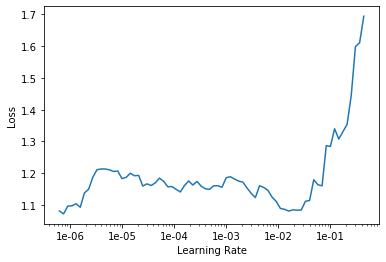

In [13]:
learner.lr_find()
learner.recorder.plot()

In [14]:
lr = 1e-4

In [15]:
learner.fit_one_cycle(cyc_len=epochs_frozen, max_lr=lr)

epoch,train_loss,valid_loss,accuracy_thresh,time
0,0.438587,1.525122,0.518116,1:14:06
1,0.293489,0.926464,0.597261,1:14:08
2,0.215412,0.580296,0.760211,1:14:05
3,0.229420,0.901737,0.635175,1:14:03
4,0.173942,0.753794,0.710860,1:13:58


In [16]:
nameHead = f'{nameBase}-head'

In [17]:
learner.save(nameHead)

In [18]:
#learner.load('bestmodel_2')

In [12]:
learner.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


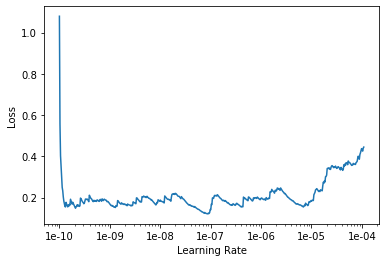

In [20]:
learner.lr_find(start_lr=1e-10, end_lr=10, num_it=1000)
learner.recorder.plot(skip_start=0)

In [15]:
lr2 = 2e-6
lr3 = 1e-5

In [16]:
from fastai.callbacks import *

In [23]:
learner.fit_one_cycle(cyc_len=epochs_unfrozen, 
                      max_lr=slice(lr2, lr3), 
                      callbacks=[SaveModelCallback(learner, every='epoch', monitor='accuracy_thresh')])

epoch,train_loss,valid_loss,accuracy_thresh,time
0,0.184146,0.837304,0.682604,1:48:09
1,0.223332,0.836381,0.693369,1:48:28
2,0.157778,0.807590,0.684959,1:48:32
3,0.183372,0.709369,0.730418,1:48:35
4,0.127702,1.082236,0.646901,1:48:34
5,0.125073,0.815303,0.679049,1:48:33
6,0.113360,0.971387,0.619894,1:48:37


KeyboardInterrupt: 

In [17]:
learner.fit_one_cycle(cyc_len=epochs_unfrozen, 
                      max_lr=slice(lr2, lr3), 
                      callbacks=[SaveModelCallback(learner, every='epoch', monitor='accuracy_thresh')],
                     start_epoch=7)

Loaded bestmodel_6


epoch,train_loss,valid_loss,accuracy_thresh,time
7,0.123810,0.762344,0.771784,1:57:18
8,0.099701,1.088122,0.767803,1:57:00
9,0.120114,1.047603,0.761598,1:56:37


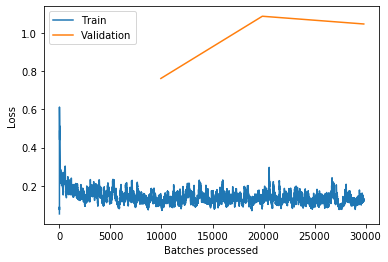

In [18]:
learner.recorder.plot_losses()

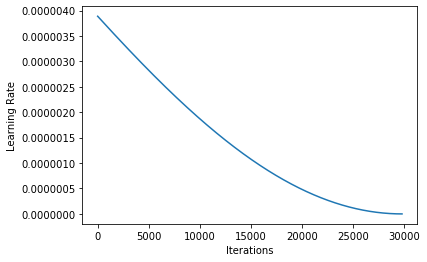

In [19]:
learner.recorder.plot_lr()

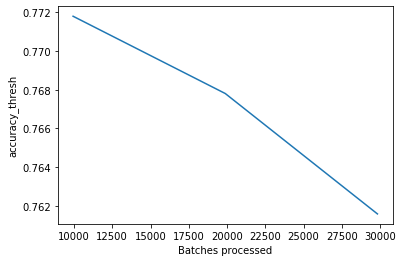

In [20]:
learner.recorder.plot_metrics()

In [21]:
nameComplete = f'{nameBase}-complete'

In [22]:
learner.save(nameComplete)

In [23]:
#learner.load(nameComplete)

# Prediction per case

In [24]:
def one_hot_encode(predicted_classes:list, all_classes:list):
    for c in predicted_classes:
        assert c in all_classes
    n = len(all_classes)
    res = np.zeros(n, int)
    for i, c in enumerate(all_classes):
        if c in predicted_classes:
            res[i] = 1 
    return res



def ensemble_predict(dict_arch_to_path_of_saved_model:typing.Dict[Callable, pathlib.Path], 
                     data:fastai.vision.data.ImageDataBunch,
                     ds_type:fastai.basic_data.DatasetType,
                     tta:bool, 
                     scale:float,
                     beta:float):
    """
    tta: Should test time augmentation be used?
    scale: if tta is True -> scaling factor for tta
    beta: if tta is True -> beta factor for tta
    check this out for more infos: https://docs.fast.ai/basic_train.html#Test-time-augmentation
    """
   
    print(f'{str([a.__name__ for a in dict_arch_to_path_of_saved_model.keys()])}_sz{sz}_ensembled')
    
    predsList = []
    for arch in dict_arch_to_path_of_saved_model.keys():
        learner = cnn_learner(data=data, base_arch=arch, pretrained=False)
        learner.load(dict_arch_to_path_of_saved_model[arch])
        if tta is True:
            preds = learner.TTA(beta=beta, scale=scale, ds_type=ds_type)
        else:
            preds = learner.get_preds(ds_type=ds_type)
            
        predsList.append(preds)
    
    preds_ensembled = predsList[0]
    for n, _ in enumerate(predsList):
        if n == 0:
            continue
        else:
            preds_ensembled[0] = preds_ensembled[0] + predsList[n][0]
    preds_ensembled[0] = preds_ensembled[0]/len(predsList)
    
    return preds_ensembled

def from_preds_to_dict_path_to_preds(preds, 
                                     imageDataBunch:fastai.vision.ImageDataBunch, 
                                     ds_type:fastai.basic_data.DatasetType,
                                     threshold:float):
    """
    preds: What fastai.vision.learner.get_preds or fastai.vision.learner.TTA return.
            two tensors: 1st: lists with raw predictions for each class of an image
                         2nd: lists with y_true
            form e.g. [tensor([[0.9672, 0.9211, 0.4560, 0.8185], 
                                [0.9498, 0.8600, 0.5852, 0.7206]]),
                         tensor([[0., 0., 0., 1.],
                                [0., 0., 1., 1.]])]
                                
    RETURN:
        key:path, value:tuple (fastai.core.MultiCategory, tensor preds one hot encoded, tensor with pure preds) 
        e.g. (MultiCategory 0, tensor([1., 0., 0., 0.]), tensor([0.9952, 0.0015, 0.0021, 0.0029]))
    path_to_pred = {}
    """
    #key:path, value:tuple (fastai.core.MultiCategory, tensor preds one hot encoded, tensor with pure preds) 
    #e.g. (MultiCategory 0, tensor([1., 0., 0., 0.]), tensor([0.9952, 0.0015, 0.0021, 0.0029]))
    path_to_pred = {}
    d = None
    if ds_type is DatasetType.Valid:
        d = imageDataBunch.valid_ds
    elif ds_type is DatasetType.Test:
        d = imageDataBunch.test_ds
    elif ds_type is DatasetType.Train:
        d = imageDataBunch.train_ds
    for path, pred in tqdm(zip(d.items, preds[0]), total = len(d.items)):
        multi_c = None
        pred_one_hot_encoded = (pred > threshold).float()
        pred_raw = pred
        path_to_pred[path] = multi_c, pred_one_hot_encoded, pred_raw
        
    return path_to_pred


def get_class_occurence_per_id(learner:fastai.vision.learner=None,
                               labelList:fastai.data_block.LabelList=None,
                               dict_arch_to_path_of_saved_model:typing.Dict[Callable, pathlib.Path]=None,
                               imageDataBunch:fastai.vision.data.ImageDataBunch=None,
                               ds_type:fastai.basic_data.DatasetType=None,
                               tta:bool=False,                                          
                               threshold = 0.5,                              
                               scale:float = 1.35,
                               beta: float = 0.4):
    """
    Option 1: Hand over a fastai.vision.learner and fastai.data_block.LabelList. No tta and no ensembling available
                for this option.
    Option 2: Hand over a fastai.vision.learner that was initalized with a fastai.vision.data.ImageDataBunch object.
    Option 3: Hand over dict where the keys are functions to create a model (e.g. torchvision.models.resnet50)
                and the values are paths to saved weights. Do this to use ensembling.
    
    Params:
        threshold:  threshold to consider the predictions to be correct or not
        scale: only needed when tta is True; scale value for fastai's fastai.basic_train.Learner.TTA function
        beta: only needed when tta is True; beta value for fastai's fastai.basic_train.Learner.TTA function
    """
    
    if labelList is not None and ds_type is not None:
        raise ValueError('One of dataset or ds_type must be None')
    if labelList is not None and tta is True:
        raise ValueError('TTA is not available for a custom LabelList')
                
    #key:path, value:tuple (fastai.core.MultiCategory, tensor preds one hot encoded, tensor with pure preds) 
    #e.g. (MultiCategory 0, tensor([1., 0., 0., 0.]), tensor([0.9952, 0.0015, 0.0021, 0.0029]))
    path_to_pred = {}
    
    #Option 1
    if learner is not None and labelList is not None:
        for n, path in tqdm(enumerate(labelList.items), total=len(labelList.items)):
            pred = learner.predict(labelList[n][0], thresh=threshold)
            path_to_pred[path] = pred
    
    #Option 2
    elif learner is not None and labelList is None and  not dict_arch_to_path_of_saved_model and imageDataBunch is None:
        if tta is True:
            preds = learner.TTA(beta=beta, scale=scale, ds_type=ds_type)
        else:
            preds = learner.get_preds(ds_type=ds_type)
        path_to_pred = from_preds_to_dict_path_to_preds(preds, learner.data, ds_type, threshold)
                
    #Option 3
    elif dict_arch_to_path_of_saved_model and imageDataBunch is not None:
        preds = ensemble_predict(dict_arch_to_path_of_saved_model, imageDataBunch, ds_type, tta, scale, beta)
        path_to_pred = from_preds_to_dict_path_to_preds(preds, imageDataBunch, ds_type, threshold)                
               
    #key: id of a case; value: list with this syntax  
    #[<number of tiles>, 
    #[<number of occurence of class1 over all tiles per id>, 
    #<number of occurence of class2 over all tiles per id>, ..., 
    #<number of occurence of classN over all tiles per id>],
    #y_true]
    class_occurence_per_id = {}
    
    for path, pred in path_to_pred.items():   
        id = get_id_from_path(path)
        if id in class_occurence_per_id:
            v = class_occurence_per_id[id]
            v[0] = v[0] + 1
            v[1] = v[1] + pred[1]
            class_occurence_per_id[id] = v
        else:
            class_occurence_per_id[id] = [1, pred[1], one_hot_encode(label_func(path), lbs2num.values())]
            
    return class_occurence_per_id


def get_preds_threshold_per_id(thresholds_per_class:list, class_occurence_per_id:dict):
    #key: id of a case; 
    #value: list with this syntax  
    #[y_pred_th e.g. [True,False,False,False], 
    #y_true e.g. [1,0,0,0]]
    result = {}
    for k in class_occurence_per_id.keys():
        y_pred_th = []
        for n, i in enumerate(class_occurence_per_id[k][1]):
            i = int(i)
            y_pred_th.append(i/class_occurence_per_id[k][0] > thresholds_per_class[n])
    
        result[k] = [y_pred_th, class_occurence_per_id[k][2]]
    return result

def get_accuracy_over_all_ids(number_of_ids, preds_threshold_per_id:dict, per_class:bool = True, number_of_classes = len(lbs2num)):
    if per_class is True:
        correctly_predicted = np.zeros(number_of_classes, dtype=np.int)
    else:
        correctly_predicted = 0
    for k in preds_threshold_per_id.keys():
        pred = preds_threshold_per_id[k][0]
        true = preds_threshold_per_id[k][1]
        for i in range(number_of_classes):
            if true[i] == pred[i]:
                if per_class is True:
                    correctly_predicted[i] = correctly_predicted[i] + 1
                else:
                    correctly_predicted = correctly_predicted + 1
    if per_class is True:                    
        correctly_predicted_percentage = {}
        for lb, num in zip(lbs2num.keys(), correctly_predicted):
            correctly_predicted_percentage[lb] = num/number_of_ids
    if per_class is False:
        correctly_predicted_percentage = correctly_predicted/number_of_ids

    return correctly_predicted_percentage

In [25]:
#arches = {resnext101_32x8d:Path(MODEL_PATH/'6-resnext101_32x8d-size512-bs8-seed_73/bestmodel_15'),
         # se_resnext101_32x4d:MODEL_PATH/'11-se_resnext101_32x4d-size512-bs10-epochs_head5-epochs_complete5-seed_73/11-se_resnext101_32x4d-size512-bs8-epochs_head5-epochs_complete5-seed_73-complete'}

In [26]:
ths = [0.5,0.5]

## val set

In [27]:
#copi_val = get_class_occurence_per_id(dict_arch_to_path_of_saved_model=arches,
#                                      imageDataBunch=data,
#                                      ds_type=DatasetType.Valid)
copi_val = get_class_occurence_per_id(learner=learner, ds_type=DatasetType.Valid)
preds_th_val = get_preds_threshold_per_id(ths, copi_val)
accuracy_per_class_val = get_accuracy_over_all_ids(len(preds_th_val), preds_th_val)

In [28]:
copi_val

{'630-12': [2712, tensor([2614.,   91.]), array([1, 0])],
 '261-12': [1957, tensor([ 466., 1478.]), array([1, 0])],
 '1285-12': [515, tensor([515.,   0.]), array([1, 0])],
 '1882-12': [107, tensor([100.,   7.]), array([1, 0])],
 '631-12': [782, tensor([761.,  20.]), array([1, 0])],
 '692-12': [297, tensor([296.,   1.]), array([1, 0])],
 '448-13': [817, tensor([ 60., 754.]), array([0, 1])],
 '10-14': [848, tensor([  0., 848.]), array([0, 1])],
 '1737-11': [756, tensor([602., 152.]), array([0, 1])],
 '744-16': [892, tensor([121., 767.]), array([0, 1])],
 '1671-12': [285, tensor([ 46., 241.]), array([0, 1])],
 '1945-14': [682, tensor([ 97., 579.]), array([0, 1])],
 '1883-12': [59, tensor([34., 26.]), array([0, 1])],
 '1452-12': [90, tensor([ 1., 89.]), array([0, 1])]}

In [29]:
preds_th_val

{'630-12': [[True, False], array([1, 0])],
 '261-12': [[False, True], array([1, 0])],
 '1285-12': [[True, False], array([1, 0])],
 '1882-12': [[True, False], array([1, 0])],
 '631-12': [[True, False], array([1, 0])],
 '692-12': [[True, False], array([1, 0])],
 '448-13': [[False, True], array([0, 1])],
 '10-14': [[False, True], array([0, 1])],
 '1737-11': [[True, False], array([0, 1])],
 '744-16': [[False, True], array([0, 1])],
 '1671-12': [[False, True], array([0, 1])],
 '1945-14': [[False, True], array([0, 1])],
 '1883-12': [[True, False], array([0, 1])],
 '1452-12': [[False, True], array([0, 1])]}

In [30]:
accuracy_per_class_val

{'non_relapse': 0.7857142857142857, 'relapse': 0.7857142857142857}

## test set

In [ ]:
#copi_test = get_class_occurence_per_id(dict_arch_to_path_of_saved_model=arches,
#                                      imageDataBunch=data,
#                                      ds_type=DatasetType.Test)
copi_test = get_class_occurence_per_id(learner=learner, ds_type=DatasetType.Test)
preds_th_test = get_preds_threshold_per_id(ths, copi_test)
accuracy_per_class_test = get_accuracy_over_all_ids(len(preds_th_test), preds_th_test)

In [ ]:
accuracy_per_class_test

# Interpreter

In [ ]:
interp = ClassificationInterpretation.from_learner(learner)

In [ ]:
def custom_confusion_matrix(self, slice_size:int=1):
        "Confusion matrix as an `np.ndarray`."
        x=torch.arange(0,self.data.c)
        if slice_size is None: cm = ((self.pred_class==x[:,None]) & (self.y_true==x[:,None,None])).sum(2)
        else:
            cm = torch.zeros(self.data.c, self.data.c, dtype=x.dtype)
            for i in range(0, self.y_true.shape[0], slice_size):
                #cm_slice = ((self.pred_class[i:i+slice_size]==x[:,None])
                            #& (self.y_true[i:i+slice_size]==x[:,None,None])).sum(2)
                cm_slice = ((self.pred_class[i:i+slice_size]==x[:,None])
                            & (self.y_true[i:i+slice_size]==(x[:,None,None]).float())).sum(2)
                torch.add(cm, cm_slice, out=cm)
        return to_np(cm)
    
fastai.train.ClassificationInterpretation.confusion_matrix = custom_confusion_matrix

In [ ]:
interp.plot_confusion_matrix()

In [ ]:
interp.plot_top_losses(10)